Import Library

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import imblearn as imb
import os
# from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, Callback
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score
from google.colab import drive

# For Early Stopping
### Create Early stopping if there is no improvement after certain epochs ###
class CustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs.get('val_loss')
        print(f"Epoch {epoch + 1}: val_loss = {val_loss}")

earlystopping = EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights = True)
custom_callback = CustomCallback()

# A. Data Sets Preparing
1. Datasets configuration


In [ ]:
drive.mount('/content/drive')

normal_dir = '/content/drive/My Drive/Datasets/TBC Datasets/TB_Chest_Radiography_Database/Train/Normal' # Path to normal lung photos
tbc_dir = '/content/drive/My Drive/Datasets/TBC Datasets/TB_Chest_Radiography_Database/Train/Tuberculosis/' # Path to TB lung photos
normal_cv_dir = '/content/drive/My Drive/Datasets/TBC Datasets/TB_Chest_Radiography_Database/Val/Normal/' # Path to normal lung photos
tbc_cv_dir = '/content/drive/My Drive/Datasets/TBC Datasets/TB_Chest_Radiography_Database/Val/Tuberculosis/' # Path to TB lung photos
normal_test_dir = '/content/drive/My Drive/Datasets/TBC Datasets/TB_Chest_Radiography_Database/Test/Normal/' # Path to normal lung photos
tbc_test_dir = '/content/drive/My Drive/Datasets/TBC Datasets/TB_Chest_Radiography_Database/Test/Tuberculosis/' # Path to TB lung photos

X_train = [] # For X sets
y_train = [] # For y-output sets
X_cv = [] # For X Cross Validation sets
y_cv = [] # For y Cross Validation sets
X_test = []
y_test= []

def load_images(folder, label, X, y):
  for filename in os.listdir(folder):
    img_path = os.path.join(folder, filename)
    if img_path.endswith('.png'):
      img = Image.open(img_path).convert('L')
      img = img.resize((224, 224))
      img_array = np.array(img)
      X.append(img_array)
      y.append(label)

load_images(normal_dir, 0, X_train, y_train)
load_images(tbc_dir, 1, X_train, y_train)
load_images(normal_cv_dir, 0, X_cv, y_cv)
load_images(tbc_cv_dir, 1, X_cv, y_cv)
load_images(normal_test_dir, 0, X_test, y_test)
load_images(tbc_test_dir, 1, X_test, y_test)
X_train = np.array(X_train)
y_train = np.array(y_train)
X_cv = np.array(X_cv)
y_cv = np.array(y_cv)
X_test = np.array(X_test)
y_test = np.array(y_test)
X_train = X_train.reshape(-1, 224, 224, 1)
X_train = X_train/255.0
X_cv = X_cv.reshape(-1, 224, 224, 1)
X_cv = X_cv/225.0
X_test = X_test.reshape(-1, 224, 224, 1)
X_test = X_test/255.0

Mounted at /content/drive


Visualize Image

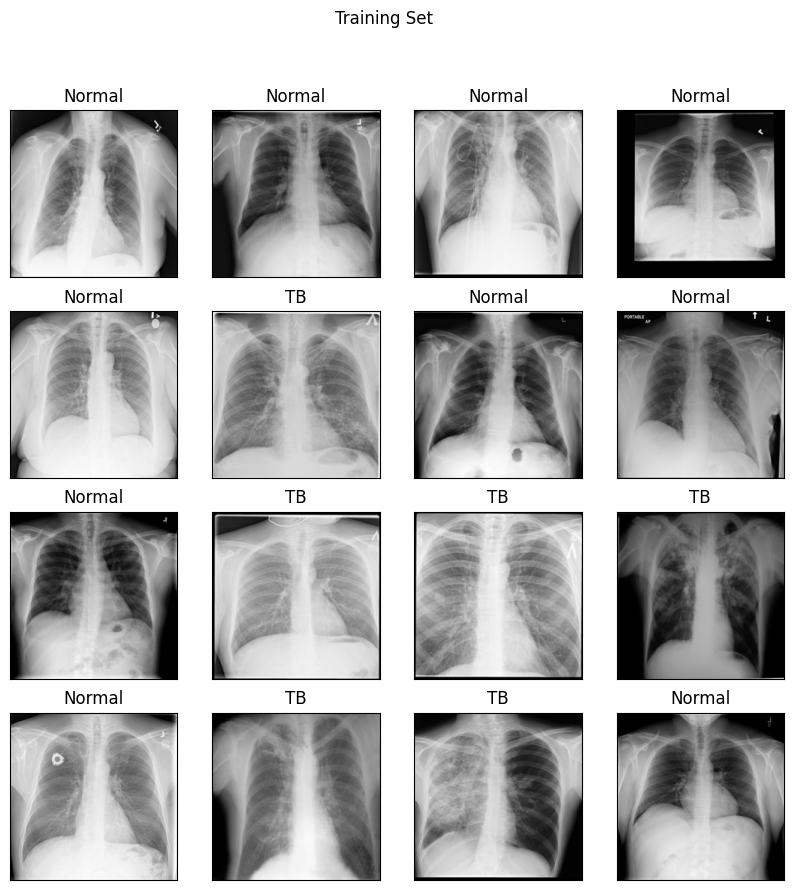

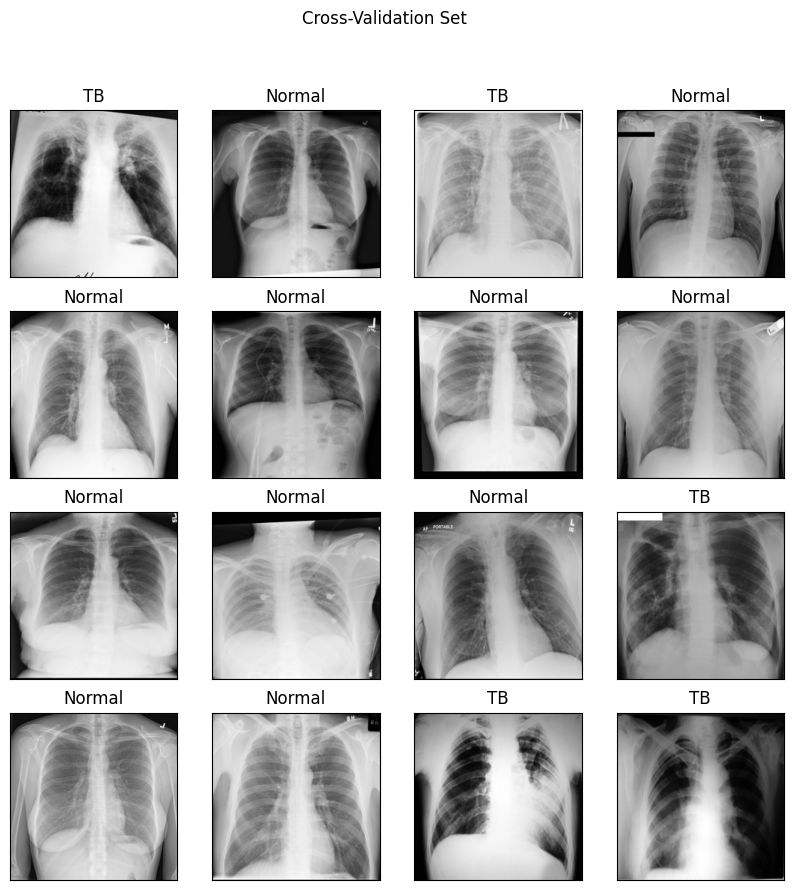

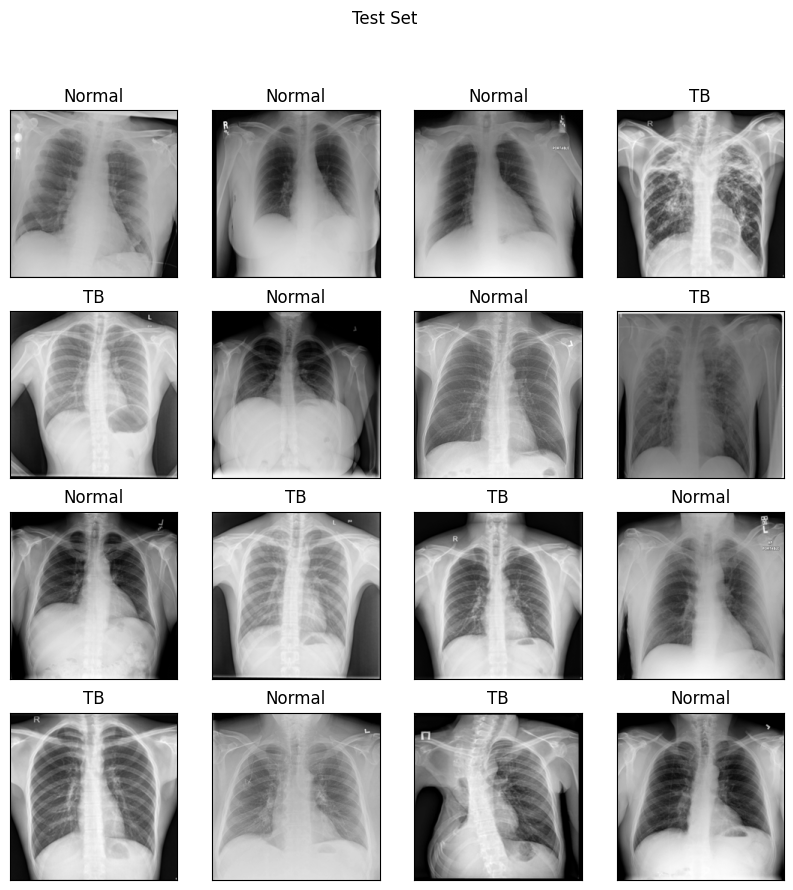

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display a grid of random images
def display_random_images(images, labels, title):
    indices = np.random.choice(len(images), 16, replace=False)  # Randomly select 16 indices
    plt.figure(figsize=(10, 10))
    for i, idx in enumerate(indices):
        plt.subplot(4, 4, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[idx].reshape(224, 224), cmap='gray')
        plt.title('TB' if labels[idx] else 'Normal')
    plt.suptitle(title)
    plt.show()

# Visualize random images from training set
display_random_images(X_train, y_train, 'Training Set')

# Visualize random images from cross-validation set
display_random_images(X_cv, y_cv, 'Cross-Validation Set')

# Visualize random images from test set
display_random_images(X_test, y_test, 'Test Set')


2. Datasets Oversampling to balance the data

In [ ]:
ROS = imb.over_sampling.RandomOverSampler()
X_train, y_train = ROS.fit_resample(X_train.reshape(-1, 224 * 224 * 1), y_train)
X_train = X_train.reshape(-1, 224, 224, 1)
X_cv, y_cv = ROS.fit_resample(X_cv.reshape(-1, 224 * 224 * 1), y_cv)
X_cv = X_cv.reshape(-1, 224, 224, 1)

def check_balance(y):
    unique, counts = np.unique(y, return_counts=True)
    balance = dict(zip(unique, counts))
    total = sum(counts)
    for k, v in balance.items():
        balance[k] = f"{v} ({v/total:.2%})"
    return balance

print("Training set balance:", check_balance(y_train))
print("Validation set balance:", check_balance(y_cv))
print("Test set balance:", check_balance(y_test))


Training set balance: {0: '2375 (50.00%)', 1: '2375 (50.00%)'}
Validation set balance: {0: '339 (50.00%)', 1: '339 (50.00%)'}
Test set balance: {0: '679 (56.07%)', 1: '532 (43.93%)'}


# **Model Architecture**


In [ ]:
model = Sequential(
  [
    Conv2D(32, (3, 3), padding= 'same', input_shape= (224, 224, 1)),
    Conv2D(64, (3, 3)),
    # LeakyReLU(negative_slope = 0.01),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3),  padding= 'same'),
    Conv2D(128, (3, 3),  padding= 'same'),
    Dropout(0.2),
    LeakyReLU(negative_slope = 0.01),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3),  padding= 'same'),
    Conv2D(128, (3, 3),  padding= 'same'),
    Dropout(0.3),
    LeakyReLU(negative_slope = 0.01),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), padding= 'same'),
    Conv2D(256, (3, 3), padding= 'same'),
    # LeakyReLU(negative_slope = 0.01),
    MaxPooling2D((2, 2)),
    Conv2D(512, (3, 3), padding= 'same'),
    Conv2D(512, (3, 3), padding= 'same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(1024, activation = 'relu'),
    Dropout(0.3),
    Dense(512, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
  ]
)

In [ ]:
model.compile(
  loss = BinaryCrossentropy(),
  optimizer = tf.keras.optimizers.Adam(0.0001),
  metrics = ['accuracy', 'binary_accuracy']
)

In [ ]:
model.fit(
  X_train, y_train,
  epochs = 10,
  batch_size = 8,
  validation_data = (X_cv, y_cv),
  callbacks = [earlystopping, custom_callback]
)

model.save('/content/drive/My Drive/Ml_Models_tensorflow/TBC Model Trained/NEW2_3.keras')

Epoch 1/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.7922 - binary_accuracy: 0.7922 - loss: 0.4464Epoch 1: val_loss = 0.12952949106693268
594/594 ━━━━━━━━━━━━━━━━━━━━ 79s 104ms/step - accuracy: 0.7924 - binary_accuracy: 0.7924 - loss: 0.4462 - val_accuracy: 0.9631 - val_binary_accuracy: 0.9631 - val_loss: 0.1295
Epoch 2/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9389 - binary_accuracy: 0.9389 - loss: 0.1680Epoch 2: val_loss = 0.19231486320495605
594/594 ━━━━━━━━━━━━━━━━━━━━ 56s 83ms/step - accuracy: 0.9389 - binary_accuracy: 0.9389 - loss: 0.1680 - val_accuracy: 0.9366 - val_binary_accuracy: 0.9366 - val_loss: 0.1923
Epoch 3/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9534 - binary_accuracy: 0.9534 - loss: 0.1152Epoch 3: val_loss = 0.09101051092147827
594/594 ━━━━━━━━━━━━━━━━━━━━ 82s 82ms/step - accuracy: 0.9534 - binary_accuracy: 0.9534 - loss: 0.1152 - val_accuracy: 0.9735 - val_binary_accuracy: 0.9735 - val_loss: 0.0910
Epoch 4/10
594/594

# **ROC Score**

38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 263ms/step
ROC Score: 0.977


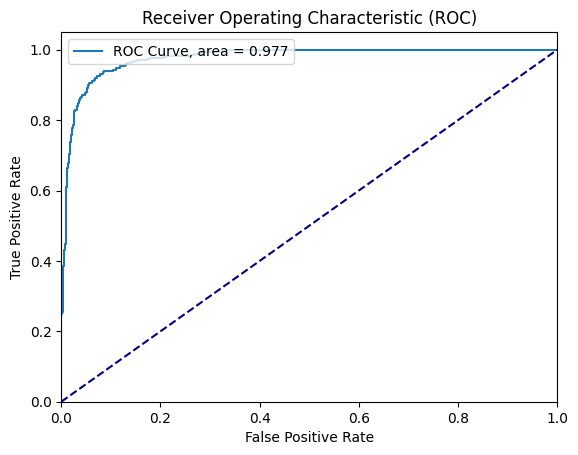

In [ ]:
predictions = model.predict(X_test).ravel()
roc_score = roc_auc_score(y_test, predictions)
print(f"ROC Score: {roc_score:.3f}")

#Plot the data
false_positive_rate, true_positive_rate, tresholds = roc_curve(y_test, predictions)
plt.figure()
plt.plot(false_positive_rate, true_positive_rate, lw=1.5, label= f"ROC Curve, area = {roc_score:.3f}")
plt.plot([0,1], [0,1], color = 'navy', lw= 1.5, linestyle= '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc = 'upper left')
plt.show()

In [ ]:
def test_algorithm(model, X, y):
  m = X.shape[0]
  Good = 0
  Bad = 0
  for i in range (m):
    predictions = model.predict(np.expand_dims(X[i], axis= 0), verbose = 0).ravel()
    # highest_predictions = np.argmax(predictions)
    if predictions < 0.5 :
      if y[i] == 0:
        Good += 1
      else:
        Bad += 1
    else:
      if y[i] == 1:
        Good += 1
      else:
        Bad +=1
  print(f"{Bad} / {Good + Bad} error test captured")
  print(f"Good percentage on test = {Good / (Good + Bad) * 100}%")
test_algorithm(model, X_test, y_test)
# Model New2_3 is 86.7% Test Accuracy

161 / 1211 error test captured
Good percentage on test = 86.70520231213872%


**Convert to TFLite**

In [ ]:
# Convert the model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the converted model to a file
with open('/content/drive/My Drive/Ml_Models_tensorflow/TBC Model Trained/NEW2_3.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model converted and saved successfully!")


Saved artifact at '/tmp/tmplv41b_ss'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name='keras_tensor_70')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  139476918095184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139476918100112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139476918103632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139476918104688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139476918106800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139476918107504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139476918103280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139476918144688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139476918101168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139476918145392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13947691810